In [1]:
import os 
os.chdir('../../Clustering')


In [59]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.metrics.pairwise import pairwise_distances

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  


# Loading The Dataset:

In [3]:
# -- load the input dataset--#
input_df=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/merged.csv', low_memory=False)
input_df.index = 'Event_' + input_df.index.astype(str)
num_rows, num_cols = input_df.shape  # at max num_rows times num_cols columns.
column_names = input_df.columns
    
print ('Input data loaded with shape', input_df.shape)     

Input data loaded with shape (2974716, 41)


## Sampling the dataset:

In [4]:
#getting all events with order type
order_type=input_df[input_df['type']=='order']
#sample same number from events with stock change
sample_stockChange=input_df[input_df['type']=='stock change'].sample(n=71152)

concated_df=pd.concat([sample_stockChange, order_type])

In [79]:
sample_df=concated_df.sample(frac=0.5, random_state=42)

In [80]:
# binarize string_labels in ['type']
lb=LabelBinarizer()
event_labels=lb.fit_transform(sample_df['type'].tolist())
lb.classes_


array(['order', 'stock change'], dtype='<U12')

<AxesSubplot:>

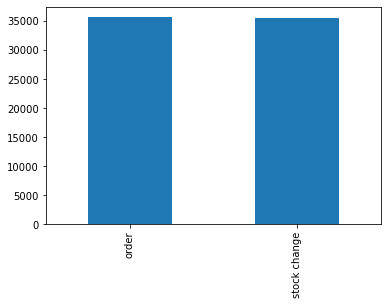

In [81]:
pd.value_counts(sample_df['type'], normalize=False).plot.bar()

## Load The Embedding Input Data:

In [8]:
#-- load the embeddings data --#
embedding_input=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/Vectograph_Results/2020-10-17 21:14:35.245291/PYKE_512_embd.csv', index_col=0)

In [82]:
#consider only events embedding (Event_id)
embedding_index=embedding_input.index.tolist()
prefix = 'Event_'
event_ids=list(filter(lambda x: x.startswith(prefix), embedding_index))
events_df=embedding_input.loc[event_ids]

In [83]:
# sampling
eventEmb_sample=events_df.loc[sample_df.index]

In [84]:
sample_df.index.equals(eventEmb_sample.index)

True

In [85]:
# split the dataset into train-test split
X_train, X_test, y_train, y_test = train_test_split( eventEmb_sample.values, event_labels, test_size=0.33, random_state=42)

# HDBSCAN Clustering

In [13]:
from joblib import Memory

cachedir = './'
mem = Memory(cachedir, verbose=0)

In [159]:
distance_matrix = pairwise_distances(X_test, metric='hamming')

In [87]:
y_list=y_test.ravel().tolist()
print (y_list.count(0), y_list.count(1), y_list.count(-1))

11718 11763 0


In [174]:
clusterer_precomputed=hdbscan.HDBSCAN(algorithm='best', alpha=0.3, metric='precomputed',  
                          min_samples=100, min_cluster_size=2000, cluster_selection_epsilon= 0.1,
                          cluster_selection_method='leaf', allow_single_cluster=False,
                          core_dist_n_jobs=-1, memory=mem)


clusterer_precomputed.fit(distance_matrix)
cluster_labels=clusterer_precomputed.labels_
print ('cluster labels: ', set(cluster_labels))
y_list=cluster_labels.tolist()
print (y_list.count(0), y_list.count(1), y_list.count(-1))

cluster labels:  {0, 1, 2, -1}
6648 10941 2610


In [176]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, cluster_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, cluster_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, cluster_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, cluster_labels, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=cluster_labels))

Accuracy: 0.511264
Precision: 0.688664
Recall: 0.511264
F1 score: 0.578263
Purity:  0.6512925343895064


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

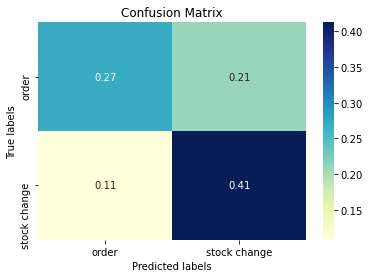

In [177]:
labels=[0, 1]
cm= confusion_matrix(y_test, cluster_labels, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])


# Random Clustering:

In [179]:
y_random=np.random.choice([0, 1], size=y_test.shape[0])

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_random))

Accuracy: 0.495550
Precision: 0.495555
Recall: 0.495550
F1 score: 0.495548
Purity:  0.5044504067118095


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

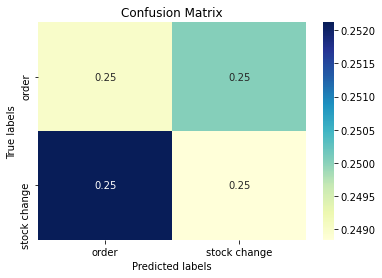

In [110]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_random, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# UnSupervisied Baselines:

## K-means

In [180]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)
y_kmeans=kmeans.predict(X_test)

    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_kmeans, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_kmeans, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_kmeans))

Accuracy: 0.499042
Precision: 0.249043
Recall: 0.499042
F1 score: 0.332269
Purity:  0.5009582215408203


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

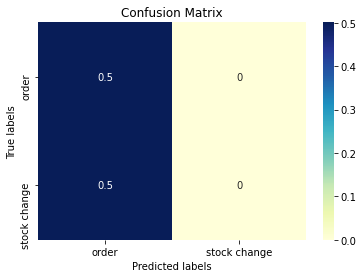

In [181]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_kmeans, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## Agglomerative Clustering

In [182]:
from sklearn.cluster import AgglomerativeClustering
aggclustering = AgglomerativeClustering(n_clusters=2).fit(X_train)

y_aggClustering=aggclustering.fit_predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_aggClustering)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_aggClustering, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_aggClustering, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_aggClustering, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_aggClustering))

Accuracy: 0.498957
Precision: 0.249021
Recall: 0.498957
F1 score: 0.332231
Purity:  0.5010433967888932


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

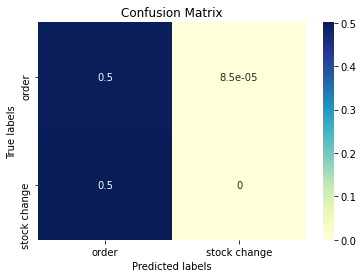

In [183]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_aggClustering, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Supervisied Baselines:

## Logistic Regression:

In [184]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.499042
Precision: 0.249043
Recall: 0.499042
F1 score: 0.332269
Purity Score:  0.5009582215408203


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

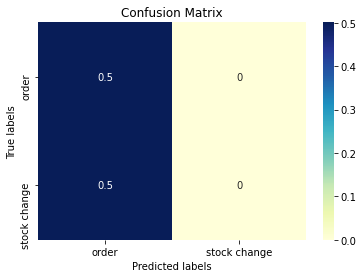

In [185]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_lr, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## KNN:

In [186]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.941314
Precision: 0.941528
Recall: 0.941314
F1 score: 0.941306
Purity Score:  0.941314254077765


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

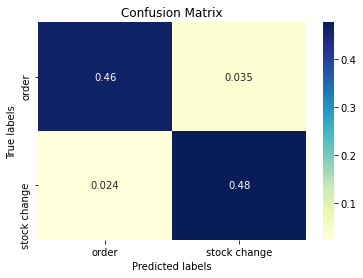

In [187]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_knn, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## RandomForest:

In [188]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.499255
Precision: 0.638730
Recall: 0.499255
F1 score: 0.332893
Purity Score:  0.5009582215408203


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

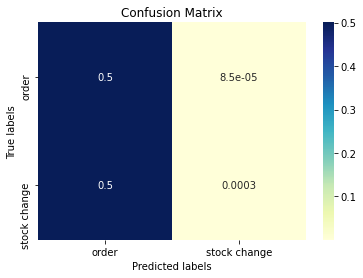

In [189]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_rf, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])